## TP2:

Au cours du TP1, nous avons étudié le modèle *Softmax* pour traiter le problème de classification probabiliste. Le but était de présenter deux étapes importantes de l'entraînement : la forward propagation et la mise à jour des paramètres. Le TP2 reprend le modèle Softmax dans un cadre plus général, celui des réseaux de neurones avec couches cachèes.
Dans ce cadre, on peut considérer le modèle Softmax comme un "module" qui prend en entrèe des "features", e.g. les pixels d'une image, et qui donne en sortie une loi de probabilité sur les étiquettes.
Un réseau de neurones est composé de plusieurs modules, transformant simplement les features d'un espace à un autre en fonction des valeurs courantes des paramètres. Ainsi, le but de l'entraînement est d'apprendre les transformations pertinentes, i.e., en modifiant les paramètres, qui permettront de réaliser la tâche associée au module de sortie. En augmentant le nombre de modules (mais aussi de fonctions non-linéaires), on augmente ainsi la complexité du modèle.

Le premier but du TP2 est de programmer les trois étapes essentielles à l'entraînement d'un réseau de neurones : la *forward propagation*, la *backpropagation* et la *mise à jour des paramètres*. Vérifiez que votre modèle fonctionne. Ensuite, vous pourrez comparer les performances de votre réseau de neurones avec celles de votre modèle Softmax de la semaine dernière.

Une fois ces bases réalisées, on va pouvoir ajouter plusieurs fonctions d'activations en plus de la classique *sigmoïde*: les *tanh* et *relu*. Vous pourrez comparer la sigmoïde et la tanh avec la relu, notamment lorsque l'on utilise 2 couches cachées ou plus. Vous pourrez aussi mettre en évidence le phénomène de sur-apprentissage (travaillez avec une petite sous partie des données si nécessaire).
Pour rappel, les fonctions sont:

$$ tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

$$ relu(x) = max(0, x) $$

Remarque: La fonction relu est plus instable numériquement que les deux autres. Il est possible qu'il soit nécessaire de réduire le taux d'apprentissage (ou de l'apapter, en le réduisant au fur et à mesure que l'apprentissage progresse) ou de forcer les valeurs de la relu à rester en dessous d'une limite que l'on choisit (*clipping*).

Enfin, on va implémenter la *régularisation*: on ajoutera à la fonction de mise à jour des paramètres les méthodes de régularisation *L1* et *L2*. Il s'agira ensuite de vérifier leur influence sur les courbes d'apprentissage en faisant varier le paramètre $\lambda$.

A faire: 
- Compléter les fonctions:
    - getDimDataset
    - sigmoid
    - forward
    - backward
    - update
    - softmax
    - computeLoss
    - getMiniBatch
- Compléter les fonctions:
    - tanh
    - relu
    - et faire les expériences demandées.
- Compléter les fonctions:
    - updateParams
    - et faire les expériences demandées.
- Envoyer le notebook avec le code complété avant le **13 décembre 2017** à l'adresse **labeau@limsi.fr** accompagné d'un résumé d'un maximum de 6 pages contenant des figures et des analyses rapides des expériences demandées.
- Le résumé doit être succinct et se focaliser uniquement sur les points essentiels reliés à l'entraînement des réseaux de neurones. En plus des résultats, ce document doit décrire les difficultés que vous avez rencontrées et, dans le cas échéant, les solutions utilisées pour les résoudre. Vous pouvez aussi y décrire vos questions ouvertes et proposer une expérience sur MNIST afin d'y répondre.



In [149]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from IPython.display import clear_output

if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

#####################
# Gestion des données
#####################  
import dataset_loader
train_set, valid_set, test_set = dataset_loader.load_cifar10()

def getDimDataset(train_set):
    #####################
    # TO BE COMPLETED
    n_training = len(train_set[0])
    n_feature = len(train_set[0][0])
    n_label = len(set(train_set[1]))
    #assert(False),"getDimDataset must be completed before testing"
    #####################   
    return n_training, n_feature, n_label

n_training, n_feature, n_label = getDimDataset(train_set)

########################
# Gestion des paramètres
########################

# Taille de la couche cachée: sous forme de liste, il est possible
# d'utiliser plusieurs couches cachées, avec par exemple [128, 64]
n_hidden = [256,128,64]

# Fonction d'activation: à choisir parmi 'sigmoid', 'tanh' et 'relu'
act_func = 'relu'

# Taille du batch
batch_size = 50

# Taux d'apprentissage:
eta = 0.1

# Nombre d'époques:
n_epoch = 20

In [150]:
def initNetwork(nn_arch, act_func_name):
    """
    Initialize the neural network weights, activation function and return the number of parameters
    Inputs: nn_arch: the number of units per hidden layer -  list of int
          : act_func_name: the activation function name (sigmoid, tanh or relu) - str
    Outputs: W: a list of weights for each hidden layer - list of ndarray
           : B: a list of bias for each hidden layer - list of ndarray
           : act_func: the activation function - function
           : nb_params: the number of parameters  - int
    """

    W,B = [],[]
    sigma = 1.0
    act_func = globals()[act_func_name] # Cast the string to a function
    nb_params = 0

    if act_func_name=='sigmoid':
        sigma = 4.0

    for i in range(np.size(nn_arch)-1):
        w = np.random.normal(loc=0.0, scale=sigma/np.sqrt(nn_arch[i]), size=(nn_arch[i+1],nn_arch[i]))
        W.append(w)
        b = np.zeros((w.shape[0],1))
        if act_func_name=='sigmoid':
            b = np.sum(w,1).reshape(-1,1)/-2.0
        B.append(b)
        nb_params += nn_arch[i+1] * nn_arch[i] + nn_arch[i+1]

    return W,B,act_func,nb_params

In [151]:
########################
# Fonctions d'activation
########################

def sigmoid(z, grad_flag=True):
    """
    Perform the sigmoid transformation to the pre-activation values
    Inputs: z: the pre-activation values - ndarray
          : grad_flag: flag for computing the derivatives w.r.t. z - boolean
    Outputs: y: the activation values - ndarray
           : yp: the derivatives w.r.t. z - ndarray
    """
    #####################
    # TO BE COMPLETED
    #####################
    # compute the sigmoid y and its derivative yp
    y = np.exp(z.T) / (np.exp(z.T) + np.ones(z.T.shape)) #get activation values of sigmoide function
    y = y.T #remain the same shape as input z

    
    yp = y * (np.ones(y.shape) - y)
    #####################
    return y, yp

# A compléter une fois que la première partie du TP finie:

def tanh(z, grad_flag=True):
    """
    Perform the tanh transformation to the pre-activation values
    Inputs: z: the pre-activation values - ndarray
          : grad_flag: flag for computing the derivatives w.r.t. z - boolean
    Outputs: y: the activation values - ndarray
    """
    #####################
    # TO BE COMPLETED
    #####################
    # compute the tanh y and its derivative yp
    exp_z = np.exp(z.T)
    exp_minus_z = np.divide(1,exp_z)  # calculate the two composants of tanh function 
    
    y = (exp_z - exp_minus_z) / (exp_z + exp_minus_z)#tanh function
    y = y.T
    
    yp = np.subtract(1,(y*y))
    #####################
    return y, yp

def relu(z, grad_flag=True):
    """
    Perform the relu transformation to the pre-activation values
    Inputs: z: the pre-activation values - ndarray
          : grad_flag: flag for computing the derivatives w.r.t. z - boolean
    Outputs: y: the activation values - ndarray
    """
    #####################
    # TO BE COMPLETED
    #####################
    # compute the relu y and its derivative yp
    y = z.clip(0,10000) # set a maximum value to prevent unstable output, especially for multi-layers when output will multiplate

    
    yp_1 = (y > 0).astype(int)
    yp_2 = (y < 10000).astype(int)
    yp = yp_1 * yp_2
    
    #####################
    return y, yp

In [152]:
####################
# Création du réseau
####################

### Network Architecture
nn_arch = np.array([n_feature] + n_hidden + [n_label])

### Create the neural network
W, B, act_func, nb_params = initNetwork(nn_arch, act_func)

In [153]:
def forward(act_func, W, B, X):
    """
    Perform the forward propagation
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
    Outputs: Y: a list of activation values - list of ndarray
           : Yp: a list of the derivatives w.r.t. the pre-activation of the activation values - list of ndarray
    """
    Y,Yp = [np.transpose(X)],[[]] #define the first layer of Y which is input layer, Yp which is empty
        
    #####################
    # TO BE COMPLETED
    for i in range (len(W)):
        Y.append(np.zeros((W[i].shape[0],Y[i].shape[1]))) #define the shape of Y in current layer
        Yp.append(np.zeros((W[i].shape[0],Y[i].shape[1])))#define the shape of Yp in current layer
        z = np.dot(W[i], Y[i]) + np.tile(B[i].reshape(W[i].shape[0],1),(1,Y[i].shape[1])) #calculate the output of current layer
        Y[i+1], Yp[i+1] = act_func(z) #execute activation function and get activation values and derivatives
    
    #####################    
    return Y, Yp

In [154]:
def backward(error, W, Yp):
    """
    Perform the backward propagation
    Inputs: error: the gradient w.r.t. to the last layer - ndarray
          : W: the weights - list of ndarray
          : Yp: the derivatives w.r.t. the pre-activation of the activation functions - list of ndarray
    Outputs: gradb: a list of gradient w.r.t. the pre-activation with this order [gradb_layer1, ..., error] - list of ndarray
    """
    gradB = [error]
    #####################
    # TO BE COMPLETED
    
    for i in range(len(W)):
        if i == 0:
            delta = gradB[i] * Yp[-(i+1)] # if calculating the gradient of the last layer, use this formular
        else:
            delta = np.dot(W[-i].T, gradB[i]) * Yp[-(i+1)]# any other condition, use this formnular
        gradB.append(delta)
    
    gradB.reverse() # get the blist of gradient in the order of [gradb_layer1, ..., error]
    
    #####################
    return gradB

In [155]:
def updateParams(theta, dtheta, eta, regularizer=None, lamda=0.):
    """
    Perform the update of the parameters
    Inputs: theta: the network parameters - ndarray
          : dtheta: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : regularizer: choice of the regularizer: None, 'L1', or 'L2'
          : lambda: hyperparamater giving the importance of the regularizer - float
    Outputs: the parameters updated - ndarray
    """
    if regularizer==None:
        return theta - eta * dtheta
    elif regularizer=='L1':
        #####################
        # TO BE COMPLETED
        return theta - eta * dtheta - eta * lamda * (np.subtract((theta > 0).astype(int) * 2, 1)) #plus constraint in first order
        #####################
        
    elif regularizer=='L2':
        #####################
        # TO BE COMPLETED
        return theta - eta * dtheta - eta * lamda * theta  #plus constraint in second order
        #####################
        

In [156]:
def update(eta, batch_size, W, B, gradB, Y, regularizer, lamda):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : batch_size: number of examples in the batch (for normalizing) - int
          : W: the weights - list of ndarray
          : B: the bias -  list of ndarray
          : gradB: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : Y: the activation values -  list of ndarray
    Outputs: W: the weights updated -  list of ndarray
           : B: the bias updated -  list of ndarray
    """
    #####################
    # TO BE COMPLETED
    # Use updateParams(W[k], grad_w, eta) and updateParams(B[k], grad_b, eta)
    # grad_b should be a vector: object.reshape(-1,1) can be useful
    
    for i in range(len(W)):
        grad_w = np.dot(gradB[i], Y[i].T) / batch_size
        W[i] = updateParams(W[i], grad_w, eta, regularizer = 'L2') # choose a regularzition function and update parameter
        
        grad_b = (np.sum(gradB[i], axis = 1) / batch_size).reshape(-1,1)
        B[i] = updateParams(B[i], grad_b, eta, regularizer = 'L2')
    
    #####################
    return W, B

In [157]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - ndarray
    Outputs: out: the activation values - ndarray
    """
    #####################
    # TO BE COMPLETED
    # compute the output of the softmax 
    
    nb_examples = z.shape[1]
    nb_lbls = z.shape[0]
    #z = np.clip(z,-500,500) # set maximum value for array z to avoid overflow
    z_max = np.max(z.T, axis = 1).reshape(nb_examples,1)
    z_max = np.tile(z_max,(1,nb_lbls))
    z_normalized = z.T - z_max
    exp_z = np.exp(z_normalized) # transpose matrix z, then calculate the exponential of all elements in the input array. 
    z_sum = np.sum(np.exp(z_normalized),axis=1).reshape(nb_examples,1) #Accumulate all values of exp_z along verticle axis
    z_sum = np.tile(z_sum,(1,nb_lbls)) # duplicate single colomn into multiple colomns, the purpose of this step is to exceute the division for matrix in the next step
    out = exp_z / z_sum # get array of sigma
    out = out.T #transpose the array to make sure that it has the same shape as input array
    
    
    #####################
    return out

In [158]:
def computeLoss(W, B, X, labels, act_func):
    """
    Compute the loss value of the current network on the full batch
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
           : accuracy: the ratio of examples that are well-classified - float
    """ 
    nb_examples = X.shape[0]
    
    one_hot = np.zeros((n_label,nb_examples))
    one_hot[labels,np.arange(nb_examples)]=1.
    ### Forward propagation
    Y, Yp = forward(act_func, W, B, X)
 
    ### Compute the softmax and the prediction
    out = softmax(Y[-1]) # get values of output layer
    label_predict = (out.T == out.T.max(axis=1, keepdims=True)) #get True or False in each position, where True will be predicted label 
    label_predict = label_predict.astype(int) # transform into int value
    
    #####################
    # TO BE COMPLETED
    # compute the loss and accuracy 
    loss_mat = -np.log(out) * one_hot #the negative log-likelihood
    loss = np.sum(loss_mat) / nb_examples # return float type loss
    
    nb_well_classified = np.sum(label_predict * one_hot.T) # get total number of well classified examples
    accuracy =  nb_well_classified / nb_examples # calculate accuracy
    #####################
       
           
    return loss, accuracy

In [159]:
def getMiniBatch(i, batch_size, train_set, one_hot):
    """
    Return a minibatch from the training set and the associated labels
    Inputs: i: the identifier of the minibatch - int
          : batch_size: the number of training examples - int
          : train_set: the training set - ndarray
          : one_hot: the one-hot representation of the labels - ndarray
    Outputs: the minibatch of examples - ndarray
           : the minibatch of labels - ndarray
           : the number of examples in the minibatch - int
    """
    
    ####################
    # TO BE COMPLETED
    # compute the begin and end indexes, and the batch size
    
    
    mini_batch_size=batch_size
    mini_batch=train_set[0][i*batch_size:(i+1)*batch_size]
    one_hot_batch=one_hot.T[i*batch_size:(i+1)*batch_size]
    #####################

    

    return mini_batch, one_hot_batch, mini_batch_size

In [160]:
def eta_decay(t):
    initial_eta = 0.12
    k = 0.1
    eta = initial_eta * np.exp(-k*t)
    return eta
    

In [161]:
# Data structures for plotting
g_i = []
g_train_loss=[]
g_train_acc=[]
g_valid_loss=[]
g_valid_acc=[]

#############################
### Auxiliary variables
#############################
cumul_time = 0.
n_batch = int(math.ceil(float(n_training)/batch_size))
regularizer = None
lamda = 0.001
#old_accuracy = []

# Convert the labels to one-hot vector
one_hot = np.zeros((n_label,n_training))
one_hot[train_set[1],np.arange(n_training)]=1.

#printDescription("Bprop", eta, nn_arch, act_func_name, batch_size, nb_params)
print("epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta") 

#############################
### Learning process
#############################
for i in range(n_epoch):
    for j in range(n_batch):

        ### Mini-batch creation
        batch, one_hot_batch, mini_batch_size = getMiniBatch(j, batch_size, train_set, one_hot)

        prev_time = time.clock()

        ### Forward propagation
        Y, Yp = forward(act_func, W, B, batch)

        ### Compute the softmax
        out = softmax(Y[-1])
        
        ### Compute the gradient at the top layer
        derror = out - one_hot_batch.T

        ### Backpropagation
        gradB = backward(derror, W, Yp)

        ### Update the parameters
        W, B = update(eta, batch_size, W, B, gradB, Y, regularizer, lamda)

        curr_time = time.clock()
        cumul_time += curr_time - prev_time

    ### Training accuracy
    train_loss, train_accuracy = computeLoss(W, B, train_set[0], train_set[1], act_func) 

    ### Valid accuracy
    valid_loss, valid_accuracy = computeLoss(W, B, valid_set[0], valid_set[1], act_func) 
    
    '''
    if i==0:
        old_accuracy.append(valid_accuracy)
    elif i==1:
        old_accuracy.append(valid_accuracy)
    elif i==2:
        old_accuracy.append(valid_accuracy)
        if old_accuracy[2]-old_accuracy[1]>old_accuracy[1]-old_accuracy[0]:
            eta *= 1.2
        else:
            eta *= 0.8
    else:
        old_accuracy[0]=old_accuracy[1]
        old_accuracy[1]=old_accuracy[2]
        old_accuracy[2]=valid_accuracy
        if old_accuracy[2]-old_accuracy[1]>old_accuracy[1]-old_accuracy[0]:
            eta *= 1.2
        else:
            eta *= 0.8
    
    '''
    
    
    
    
    
    eta = eta_decay(i+1)
    #eta = 0.1
    
    g_i = np.append(g_i, i)
    g_train_loss = np.append(g_train_loss, train_loss)
    g_train_acc = np.append(g_train_acc, train_accuracy)
    g_valid_loss = np.append(g_valid_loss, valid_loss)
    g_valid_acc = np.append(g_valid_acc, valid_accuracy)
    result_line = str(i) + " " + str(cumul_time) + " " + str(train_loss) + " " + str(train_accuracy) + " " + str(valid_loss) + " " + str(valid_accuracy) + " " + str(eta)

    print(result_line)
    sys.stdout.flush() # Force emptying the stdout buffer

epoch time(s) train_loss train_accuracy valid_loss valid_accuracy eta
0 18.083945999989737 1.78139270955 0.37836 1.77200224982 0.3829 0.108580490164
1 34.57020899999543 1.66847433223 0.41 1.66546355504 0.4136 0.0982476903694
2 51.07242099999985 1.6036540027 0.42224 1.61358876112 0.4236 0.0888981864818
3 68.7317970000081 1.58467733638 0.4238 1.60178582289 0.4186 0.0804384055243
4 86.00721400002203 1.51226007962 0.45302 1.54750825191 0.4426 0.0727836791655
5 103.56096300002037 1.44417964712 0.48216 1.49335642929 0.4686 0.0658573963313
6 120.7171480000211 1.44676048602 0.48282 1.50845459322 0.4622 0.059590236455
7 137.8394780000217 1.40035468304 0.50014 1.48013307087 0.4737 0.0539194756941
8 155.630213000019 1.37034688545 0.51048 1.46362838682 0.4825 0.0487883591689
9 173.83174600001303 1.33877655201 0.52498 1.45020372487 0.4846 0.0441455329406
10 191.70353900000964 1.31817258481 0.53032 1.44805128734 0.4864 0.0399445300438
11 209.53247400001874 1.2975774818 0.5389 1.44132086828 0.4917 0.

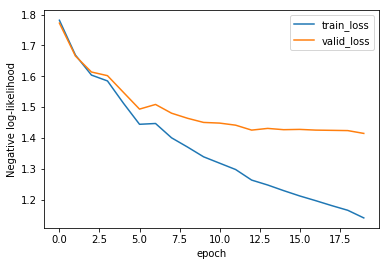

In [162]:
plt.plot(g_i,g_train_loss,label='train_loss')
plt.plot(g_i,g_valid_loss,label='valid_loss')
plt.xlabel("epoch")
plt.ylabel("Negative log-likelihood")
plt.legend()

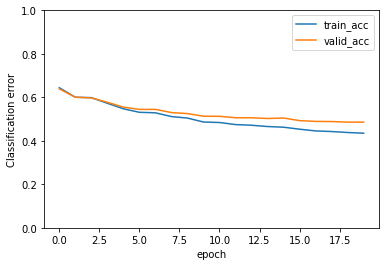

In [134]:
plt.plot(g_i,1.0-g_train_acc,label='train_acc')
plt.plot(g_i,1.0-g_valid_acc,label='valid_acc')
plt.xlabel("epoch")
plt.ylabel("Classification error")
plt.ylim([0.,1.])
plt.legend()